<a href="https://colab.research.google.com/github/napsternxg/HASOC2019/blob/master/notebooks/HASOC_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
pip install torch pytorch-transformers tensorboardX tf-nightly-2.0-preview
# Install apex
if [ ! -d "/content/apex" ]; then
  git clone https://github.com/NVIDIA/apex.git
  pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /content/apex
else
  echo "Apex cloned and installed";
fi

Apex cloned and installed


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%env HASOC_PATH /content/gdrive/My Drive/HASOC2019/

env: HASOC_PATH=/content/gdrive/My Drive/HASOC2019/


In [4]:
%%bash 
echo "${HASOC_PATH}"
ls -ltrh "${HASOC_PATH}/data"
realpath "${HASOC_PATH}"
ls -ltrh "${HASOC_PATH}"/data/**/*

/content/gdrive/My Drive/HASOC2019/
total 4.0K
drwx------ 5 root root 4.0K Aug 20 05:37 raw
/content/gdrive/My Drive/HASOC2019
/content/gdrive/My Drive/HASOC2019//data/raw/training_data:
total 3.6M
-rw------- 1 root root 1.7M Aug 20 05:37 hindi_dataset.tsv
-rw------- 1 root root 762K Aug 20 05:37 german_dataset.tsv
-rw------- 1 root root 1.2M Aug 20 05:37 english_dataset.tsv

/content/gdrive/My Drive/HASOC2019//data/raw/test_data:
total 973K
-rw------- 1 root root 594K Aug 20 05:37 hindi_dataset.tsv
-rw------- 1 root root 167K Aug 20 05:37 german_dataset.tsv
-rw------- 1 root root 212K Aug 20 05:37 english_dataset.tsv

/content/gdrive/My Drive/HASOC2019//data/raw/teaser_data:
total 293K
-rw------- 1 root root  36K Aug 20 05:37 hindi_dataset.tsv
-rw------- 1 root root 137K Aug 20 05:37 german_dataset.tsv
-rw------- 1 root root 121K Aug 20 05:37 english_dataset.tsv


In [0]:
%load_ext tensorboard
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
BASE_PATH = os.environ.get("HASOC_PATH")
DATA_PATHS_TRAIN = {
    "EN": f"{BASE_PATH}/data/raw/training_data/english_dataset.tsv",
    "DE": f"{BASE_PATH}/data/raw/training_data/german_dataset.tsv",
    "HI": f"{BASE_PATH}/data/raw/training_data/hindi_dataset.tsv"
}
DATA_PATHS_DEV = {
    "EN": f"{BASE_PATH}/data/raw/teaser_data/english_dataset.tsv",
    "DE": f"{BASE_PATH}/data/raw/teaser_data/german_dataset.tsv",
    "HI": f"{BASE_PATH}/data/raw/teaser_data/hindi_dataset.tsv"
}
print(DATA_PATHS_TRAIN)
DATA_COLUMNS = ["row_id", "text", "task_1", "task_2", "task_3"]
NUM_LANGUAGES = len(DATA_PATHS_TRAIN)

{'EN': '/content/gdrive/My Drive/HASOC2019//data/raw/training_data/english_dataset.tsv', 'DE': '/content/gdrive/My Drive/HASOC2019//data/raw/training_data/german_dataset.tsv', 'HI': '/content/gdrive/My Drive/HASOC2019//data/raw/training_data/hindi_dataset.tsv'}


train
dev


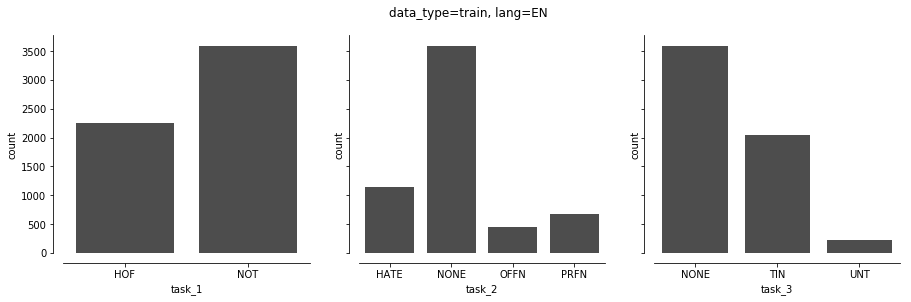

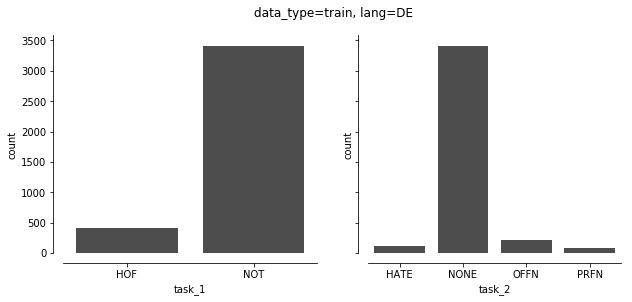

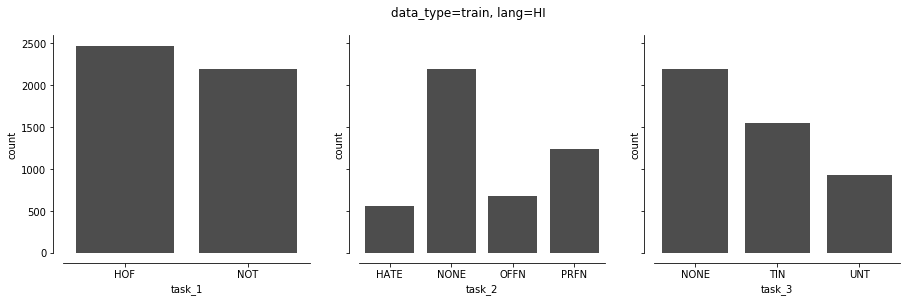

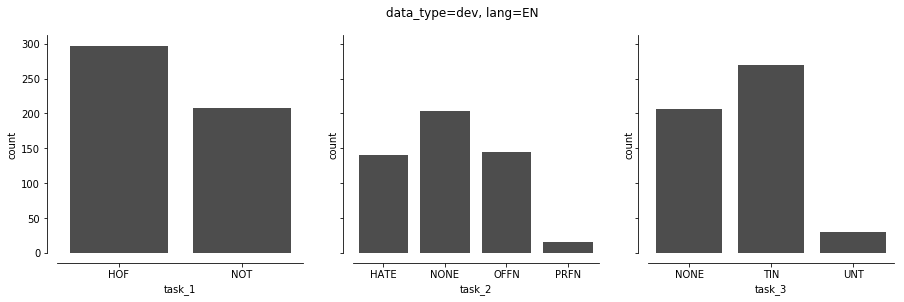

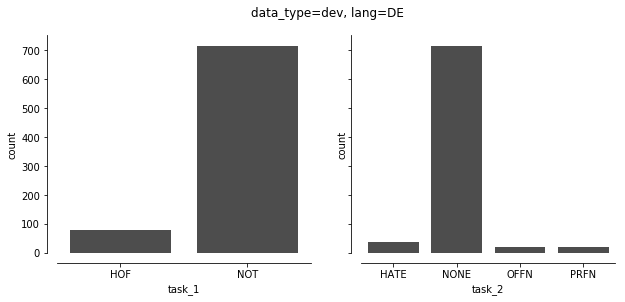

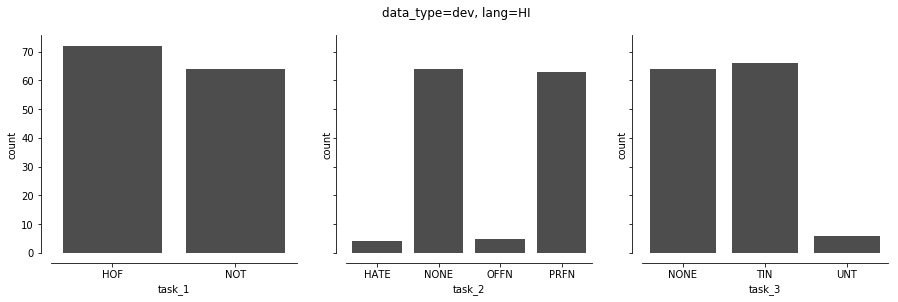

In [7]:
for data_type, DATA_PATHS in [("train", DATA_PATHS_TRAIN), ("dev", DATA_PATHS_DEV)]:
    print(data_type)
    for lang, path in DATA_PATHS.items():
        df = pd.read_csv(path, sep="\t").fillna("NULL")
        task_cols = df.filter(regex=r'task_*', axis=1).columns
        n_cols = len(task_cols)
        fig, ax = plt.subplots(1, n_cols, sharey=True, figsize=(5*n_cols, 4))
        for axi, task in zip(ax.flatten(), task_cols):
            y = df[task].str.upper().replace("NULL", "NONE")
            sns.countplot(y, order=sorted(y.unique()), ax=axi, color="0.3")
        fig.suptitle(f"data_type={data_type}, lang={lang}")
        sns.despine(offset=10)

In [0]:
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
from pytorch_transformers import *

In [0]:
MODELS = [(BertModel,       BertTokenizer,      'bert-base-cased'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer, 'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,      'gpt2'),
          (TransfoXLModel,  TransfoXLTokenizer, 'transfo-xl-wt103'),
          (XLNetModel,      XLNetTokenizer,     'xlnet-base-cased'),
          (XLMModel,        XLMTokenizer,       'xlm-mlm-enfr-1024'),
          (RobertaModel,    RobertaTokenizer,   'roberta-base')]

In [0]:
BERT_MODEL_TYPE='bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_TYPE, do_lower_case=False)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_TYPE, num_labels=3)

In [0]:
input_ids = torch.tensor([tokenizer.encode(f"{tokenizer.cls_token} Let's see all hidden-states and attentions on this text {tokenizer.sep_token}")])

In [12]:
with torch.no_grad():
  print(model(input_ids, labels=torch.LongTensor([[0]])))

(tensor(1.1811), tensor([[-0.0554,  0.1293, -0.0018]]))


In [13]:
input_ids

tensor([[ 101, 2421,  112,  188, 1267, 1155, 4610,  118, 2231, 1105, 2209, 1116,
         1113, 1142, 3087,  102]])

In [14]:
tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])

['[CLS]',
 'Let',
 "'",
 's',
 'see',
 'all',
 'hidden',
 '-',
 'states',
 'and',
 'attention',
 '##s',
 'on',
 'this',
 'text',
 '[SEP]']

In [15]:
tokenizer.cls_token

'[CLS]'

In [16]:
TASK_LABEL_IDS = {
    "task_1": ["NOT", "HOF"],
    "task_2": ["HATE", "OFFN", "PRFN"],
    "task_3": ["TIN", "UNT"],
}

for data_type, DATA_PATHS in [("train", DATA_PATHS_TRAIN), ("dev", DATA_PATHS_DEV)]:
    print(data_type)
    for lang, path in DATA_PATHS.items():
        df = pd.read_csv(path, sep="\t").fillna("NULL")
        task_cols = df.filter(regex=r'task_*', axis=1).columns
        n_cols = len(task_cols)
        for task in task_cols:
            y = df[task].str.upper().replace("NULL", "NONE")
            idx = (y != "NONE")
            df_t = df[idx]
            df_bert = pd.DataFrame({
              'id':list(range(df_t.shape[0])),
              'label':y[idx],
              'alpha':['a']*df_t.shape[0],
              'text': df_t["text"].replace(r'\n', ' ', regex=True)
            })
            os.makedirs(os.path.join("./", lang, task), exist_ok=True)
            bert_format_path = os.path.join("./", lang, task, f"{data_type}.tsv")
            print(bert_format_path)
            df_bert.to_csv(bert_format_path, sep='\t', index=False, header=False)

train
./EN/task_1/train.tsv
./EN/task_2/train.tsv
./EN/task_3/train.tsv
./DE/task_1/train.tsv
./DE/task_2/train.tsv
./HI/task_1/train.tsv
./HI/task_2/train.tsv
./HI/task_3/train.tsv
dev
./EN/task_1/dev.tsv
./EN/task_2/dev.tsv
./EN/task_3/dev.tsv
./DE/task_1/dev.tsv
./DE/task_2/dev.tsv
./HI/task_1/dev.tsv
./HI/task_2/dev.tsv
./HI/task_3/dev.tsv


In [0]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        df = pd.read_csv(input_file, sep="\t", header=None)
        return df.values.tolist()

In [0]:
class ClassificationProcessor(DataProcessor):
    """Processor for binary classification dataset."""

    def __init__(self, task_labels):
      self.labels = task_labels

    def get_train_examples(self, data_dir):
        """See base class."""
        lines = self._read_tsv(os.path.join(data_dir, "train.tsv"))
        examples = self._create_examples(lines, "train")
        return examples

    def get_dev_examples(self, data_dir):
        """See base class."""
        lines = self._read_tsv(os.path.join(data_dir, "dev.tsv"))
        examples = self._create_examples(lines, "dev")
        return examples

    def get_labels(self):
        """See base class."""
        return self.labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [0]:
MAX_SEQ_LENGTH = 128
TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

In [0]:
import logging
logger = logging.getLogger(__name__)

In [0]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False,
                                 cls_token='[CLS]',
                                 cls_token_segment_id=1,
                                 sep_token='[SEP]',
                                 sep_token_extra=False,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0, 
                                 sequence_b_segment_id=1,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3". " -4" for RoBERTa.
            special_tokens_count = 4 if sep_token_extra else 3
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - special_tokens_count)
        else:
            # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
            special_tokens_count = 3 if sep_token_extra else 2
            if len(tokens_a) > max_seq_length - special_tokens_count:
                tokens_a = tokens_a[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = tokens_a + [sep_token]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [0]:
def load_and_cache_examples(data_dir, task, tokenizer, evaluate=False):
    processor = ClassificationProcessor(TASK_LABEL_IDS[task])
    output_mode = OUTPUT_MODE
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(data_dir, 'cached_{}_{}_{}_{}'.format(
        'dev' if evaluate else 'train',
        BERT_MODEL_TYPE,
        str(MAX_SEQ_LENGTH),
        str(task)))
    if os.path.exists(cached_features_file):
        logger.info(f"Loading features from cached file {cached_features_file}")
        features = torch.load(cached_features_file)
    else:
        logger.info(f"Creating features from dataset file at {data_dir}", )
        examples = processor.get_dev_examples(data_dir) if evaluate else processor.get_train_examples(data_dir)
        label_list = processor.get_labels()
        features = convert_examples_to_features(examples, label_list, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE,
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
        )
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
import random
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
import json

In [0]:
def evaluate(eval_dataset, model, task_labels=None):
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=TRAIN_BATCH_SIZE)

    # Eval!
    logger.info("***** Running evaluation {} *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    device = "cuda:0"
    for batch in tqdm(eval_dataloader, desc="Evaluating", disable=True):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],  # XLM and RoBERTa don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    clf_report = classification_report(
        y_true=out_label_ids, y_pred=preds, output_dict=True,
        target_names=task_labels
    )
    results = {"eval_loss": eval_loss}
    for lbl, score_dict in clf_report.items():
      if isinstance(score_dict, float):
        results[lbl] = score_dict
        continue
      for score, v in score_dict.items():
        results[f"{lbl}_{score}"] = v 
    return results

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def train(train_dataset, model, tokenizer, eval_dataset=None, data_dir="./", task_labels=None):
    """ Train the model """
    save_steps = 5
    tb_writer = SummaryWriter(data_dir)

    train_batch_size = TRAIN_BATCH_SIZE
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)
    max_steps = 10
    if max_steps > 0:
        t_total = max_steps
        num_train_epochs = max_steps // (len(train_dataloader) // GRADIENT_ACCUMULATION_STEPS) + 1
    else:
        t_total = len(train_dataloader) // GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0, t_total=t_total)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", NUM_TRAIN_EPOCHS)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                   train_batch_size * GRADIENT_ACCUMULATION_STEPS)
    logger.info("  Gradient Accumulation steps = %d", GRADIENT_ACCUMULATION_STEPS)
    logger.info("  Total optimization steps = %d", t_total)

    device = 'cuda:0'

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(NUM_TRAIN_EPOCHS), desc="Epoch", disable=True)
    set_seed(1337)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)

            if GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / GRADIENT_ACCUMULATION_STEPS
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            tr_loss += loss.item()
            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                # Log metrics
                results = evaluate(train_dataset, model, task_labels=task_labels)
                print(f"[train]\tglobal_step={global_step}, results={results}")
                results["global_step"] = global_step
                results["tr_loss"] = tr_loss
                with open(os.path.join(data_dir, "train_results.json"), "a") as results_fp:
                  print(json.dumps(results), file=results_fp)
                for key, value in results.items():
                    tb_writer.add_scalar('train_{}'.format(key), value, global_step)
                
                results = evaluate(eval_dataset, model, task_labels=task_labels)
                print(f"[dev]\tglobal_step={global_step}, results={results}")
                results["global_step"] = global_step
                results["tr_loss"] = tr_loss
                with open(os.path.join(data_dir, "dev_results.json"), "a") as results_fp:
                  print(json.dumps(results), file=results_fp)
                for key, value in results.items():
                    tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    
                tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                tb_writer.add_scalar('loss', (tr_loss - logging_loss)/3, global_step)
                logging_loss = tr_loss

                if save_steps > 0 and global_step % 5 == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(data_dir, 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)
            if max_steps > 0 and global_step > max_steps:
                epoch_iterator.close()
                break
        if max_steps > 0 and global_step > max_steps:
            train_iterator.close()
            break

    tb_writer.close()

    return global_step, tr_loss / global_step


In [0]:
torch.cuda.empty_cache()

lang, task = "EN", "task_2"
task_labels = TASK_LABEL_IDS[task]
processor = ClassificationProcessor(task_labels)
DATA_DIR = os.path.join("./", lang, task)

In [26]:
! ps ax | grep tensorboard

   5763 ?        S      0:00 /bin/bash -c  ps ax | grep tensorboard
   5765 ?        S      0:00 grep tensorboard


In [27]:
%tensorboard --logdir ./EN

Reusing TensorBoard on port 6006 (pid 902), started 4:07:37 ago. (Use '!kill 902' to kill it.)

In [28]:
BERT_MODEL_TYPE='bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_TYPE, do_lower_case=False)

train_dataset = load_and_cache_examples(DATA_DIR, task, tokenizer, evaluate=False)
eval_dataset = load_and_cache_examples(DATA_DIR, task, tokenizer, evaluate=True)

model = BertForSequenceClassification.from_pretrained(BERT_MODEL_TYPE, num_labels=len(task_labels))
model.to('cuda:0')

global_step, tr_loss = train(train_dataset, model, tokenizer, eval_dataset, data_dir=DATA_DIR, task_labels=task_labels)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[train]	global_step=1, results={'eval_loss': 1.0980593009998925, 'HATE_precision': 0.0, 'HATE_recall': 0.0, 'HATE_f1-score': 0.0, 'HATE_support': 1143, 'OFFN_precision': 0.0, 'OFFN_recall': 0.0, 'OFFN_f1-score': 0.0, 'OFFN_support': 451, 'PRFN_precision': 0.2950022114108801, 'PRFN_recall': 1.0, 'PRFN_f1-score': 0.45560109289617484, 'PRFN_support': 667, 'accuracy': 0.2950022114108801, 'macro avg_precision': 0.09833407047029337, 'macro avg_recall': 0.3333333333333333, 'macro avg_f1-score': 0.15186703096539161, 'macro avg_support': 2261, 'weighted avg_precision': 0.08702630473730961, 'weighted avg_recall': 0.2950022114108801, 'weighted avg_f1-score': 0.1344033299255854, 'weighted avg_support': 2261}
[dev]	global_step=1, results={'eval_loss': 1.2303570967454176, 'HATE_precision': 0.0, 'HATE_recall': 0.0, 'HATE_f1-score': 0.0, 'HATE_support': 141, 'OFFN_precision': 0.0, 'OFFN_recall': 0.0, 'OFFN_f1-score': 0.0, 'OFFN_support': 145, 'PRFN_precision': 0.052980132450331126, 'PRFN_recall': 1.0,

In [29]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir ./EN (started 4:11:57 ago; pid 902)


In [0]:
torch.cuda.empty_cache()

lang, task = "EN", "task_1"
task_labels = TASK_LABEL_IDS[task]
processor = ClassificationProcessor(task_labels)
DATA_DIR = os.path.join("./", lang, task)

In [31]:
BERT_MODEL_TYPE='bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_TYPE, do_lower_case=False)

train_dataset = load_and_cache_examples(DATA_DIR, task, tokenizer, evaluate=False)
eval_dataset = load_and_cache_examples(DATA_DIR, task, tokenizer, evaluate=True)

model = BertForSequenceClassification.from_pretrained(BERT_MODEL_TYPE, num_labels=len(task_labels))
model.to('cuda:0')

global_step, tr_loss = train(train_dataset, model, tokenizer, eval_dataset, data_dir=DATA_DIR, task_labels=task_labels)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[train]	global_step=1, results={'eval_loss': 0.680732725707234, 'NOT_precision': 0.6136363636363636, 'NOT_recall': 1.0, 'NOT_f1-score': 0.7605633802816901, 'NOT_support': 3591, 'HOF_precision': 0.0, 'HOF_recall': 0.0, 'HOF_f1-score': 0.0, 'HOF_support': 2261, 'accuracy': 0.6136363636363636, 'macro avg_precision': 0.3068181818181818, 'macro avg_recall': 0.5, 'macro avg_f1-score': 0.38028169014084506, 'macro avg_support': 5852, 'weighted avg_precision': 0.3765495867768595, 'weighted avg_recall': 0.6136363636363636, 'weighted avg_f1-score': 0.46670934699103717, 'weighted avg_support': 5852}
[dev]	global_step=1, results={'eval_loss': 0.8472877740859985, 'NOT_precision': 0.41188118811881186, 'NOT_recall': 1.0, 'NOT_f1-score': 0.5834502103786816, 'NOT_support': 208, 'HOF_precision': 0.0, 'HOF_recall': 0.0, 'HOF_f1-score': 0.0, 'HOF_support': 297, 'accuracy': 0.41188118811881186, 'macro avg_precision': 0.20594059405940593, 'macro avg_recall': 0.5, 'macro avg_f1-score': 0.2917251051893408, 'ma

In [32]:
torch.cuda.empty_cache()

lang, task = "EN", "task_3"
task_labels = TASK_LABEL_IDS[task]
processor = ClassificationProcessor(task_labels)
DATA_DIR = os.path.join("./", lang, task)


BERT_MODEL_TYPE='bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_TYPE, do_lower_case=False)

train_dataset = load_and_cache_examples(DATA_DIR, task, tokenizer, evaluate=False)
eval_dataset = load_and_cache_examples(DATA_DIR, task, tokenizer, evaluate=True)

model = BertForSequenceClassification.from_pretrained(BERT_MODEL_TYPE, num_labels=len(task_labels))
model.to('cuda:0')

global_step, tr_loss = train(train_dataset, model, tokenizer, eval_dataset, data_dir=DATA_DIR, task_labels=task_labels)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[train]	global_step=1, results={'eval_loss': 0.4590335896140651, 'TIN_precision': 0.9026979212737727, 'TIN_recall': 1.0, 'TIN_f1-score': 0.9488609948860995, 'TIN_support': 2041, 'UNT_precision': 0.0, 'UNT_recall': 0.0, 'UNT_f1-score': 0.0, 'UNT_support': 220, 'accuracy': 0.9026979212737727, 'macro avg_precision': 0.45134896063688634, 'macro avg_recall': 0.5, 'macro avg_f1-score': 0.47443049744304977, 'macro avg_support': 2261, 'weighted avg_precision': 0.8148635370719902, 'weighted avg_recall': 0.9026979212737727, 'weighted avg_f1-score': 0.8565348476614459, 'weighted avg_support': 2261}
[dev]	global_step=1, results={'eval_loss': 0.4800882041454315, 'TIN_precision': 0.8996655518394648, 'TIN_recall': 1.0, 'TIN_f1-score': 0.9471830985915493, 'TIN_support': 269, 'UNT_precision': 0.0, 'UNT_recall': 0.0, 'UNT_f1-score': 0.0, 'UNT_support': 30, 'accuracy': 0.8996655518394648, 'macro avg_precision': 0.4498327759197324, 'macro avg_recall': 0.5, 'macro avg_f1-score': 0.4735915492957746, 'macro 